# Astronomical Coordinates 2: Transforming Between Coordinate Systems and Planning Observations

## Authors
Adrian Price-Whelan

## Learning Goals
* TODO

## Keywords
coordinates


## Summary

In the previous tutorial in this series, we showed how astronomical coordinates in the ICRS or equatorial coordinate system can be represented in Python using the `SkyCoord` object ([docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html)). There are many other coordinate systems that are commonly used in astronomical research. For example, the Galactic coordinate system is often used in radio astronomy and Galactic science, the "horizontal" or altitude-azimuth frame is often used for observatory-specific observation planning, and Ecliptic coordinates are often used for solar system science or space mission footprints. All of these coordinate frames (and others!) are supported by `astropy.coordinates`, and as we will see below, the `SkyCoord` object is designed to make transforming between these systems as straightforward as possible.

In this tutorial, we will explore how the `astropy.coordinates` package can be used to transform astronomical coordinates between different coordinate systems or frames. You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link. 

*Note: This is the 2nd tutorial in a series of tutorials about astropy.coordinates. If you are new to astropy.coordinates, you may want to start from the beginning or an earlier tutorial.*
- [Previous tutorial: Astronomical Coordinates 1 - Getting Started](1-Coordinates-Intro)
- [Next tutorial: Astronomical Coordinates 3 - Crossmatching](3-Coordinates-Crossmatch)

## Imports

We start by importing some general packages we will need below:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file

## Transforming between coordinate systems



In [4]:
tbl = QTable.read('gaia-open-clusters.ecsv')

In [8]:
open_cluster_c = SkyCoord(
    ra=tbl['ra'],
    dec=tbl['dec'],
    distance=tbl['distance'],
    frame='icrs')

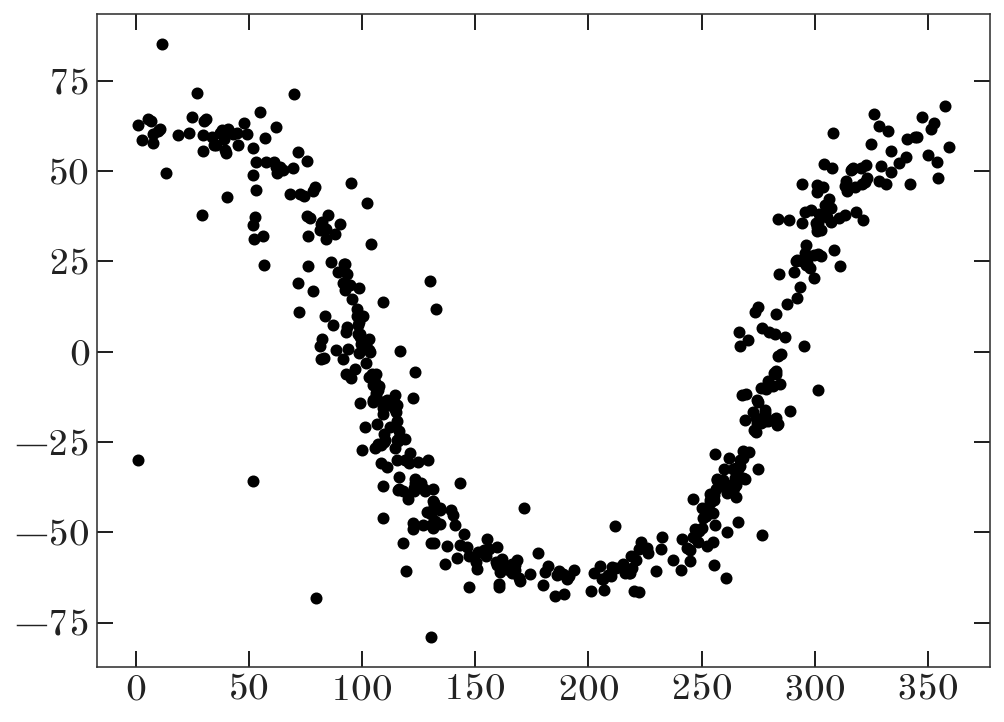

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(open_cluster_c.ra.degree,
           open_cluster_c.dec.degree)

# ax.set_xlim(360, 0)

To understand the code in this section, it may help to read over the [overview of the astropy coordinates scheme](http://astropy.readthedocs.org/en/stable/coordinates/index.html#overview-of-astropy-coordinates-concepts).  The key concept to understand is that all coordinates in astropy are in particular reference "frames", and we can transform between a specific `SkyCoord` object in one frame to another. For example, we can transform our previously-defined center of NGC 188 from ICRS to another coordinate frame, like Galactic coordinates. In `astropy.coordinates`, this is typically done using the `.transform_to()` method:

In [ ]:
ngc188_center.transform_to('galactic')

This method either takes a string name of a coordinate frame, or an instance of a coordinate frame object itself. For example, the class representing the Galactic frame is:

In [ ]:
from astropy.coordinates import Galactic
ngc188_center.transform_to(Galactic())

For coordinate frames that do not require additional parameters, the transformations can also be accessed by attributes of the `SkyCoord` object. Another way to transform to the Galactic frame, then, is to do:

In [ ]:
ngc188_center.galactic

Note that changing frames also changes some of the attributes of the object, most often the names of the component attributes. Recall that for the ICRS frame the components were `ra` and `dec`; For the Galactic frame, the corresponding longitude and latitude are named `l` and `b`:

In [ ]:
ngc188_gal = ngc188_center.galactic
ngc188_gal.l, ngc188_gal.b

Note that the names `.ra` and `.dec` will therefore *not* work on this transformed `SkyCoord`:

In [ ]:
# THIS SHOULD ERROR:
ngc188_gal.ra

### Using frame transformations to get to AltAz

To determine whether a target is observable from a given observatory on Earth, we need to convert our coordinate to a frame local to an on-earth observer. The most common choice for such a frame is horizontal coordinates, or "AltAz" coordinates. The `AltAz` coordinate frame requires a few extra pieces of information to define: a location on Earth, and the time of observation. These are handled with the `EarthLocation` and `Time` objects, respectively:

In [ ]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

Let's assume we will be observing at Kitt Peak in a few weeks. We can easily retrieve the Earth location of Kitt Peak using the `EarthLocation.of_site` method:

In [ ]:
observing_location = EarthLocation.of_site('Kitt Peak')
# List of all locations can be viewed using
# EarthLocation.get_site_names()

And let's pretend our observing run starts on Jan 20 this year:

In [ ]:
observing_time = Time('2020-01-20 1:00')  # 1am UTC=6pm AZ mountain time

Now we use these to create an `AltAz` frame object. Note that this frame has even more information about the atmosphere, which can be used to correct for atmospheric refraction. Here we leave that alone, because the default is to ignore this effect (by setting the air pressure to 0).

In [ ]:
from astropy.coordinates import AltAz

altaz = AltAz(location=observing_location, obstime=observing_time)
altaz

Now we can just transform our ICRS `SkyCoord` to `AltAz` to get the location in the sky over Kitt Peak at the requested time:

In [ ]:
ngc188_center.transform_to(altaz)

Alright, the cluster NGC 188 is up at 6PM local time at Kitt Peak, but that is pretty early to be observing. We could just try various times one at a time to see if the airmass is at a darker time, but we can do better: We can make an airmass plot for the whole night:

In [ ]:
# this gives a Time object with an *array* of times
delta_hours = np.linspace(0, 6, 100)*u.hour
full_night_times = observing_time + delta_hours
full_night_altaz = AltAz(location=observing_location, obstime=full_night_times)
full_night_altaz_coords = ngc188_center.transform_to(full_night_altaz)

plt.plot(delta_hours, full_night_altaz_coords.secz)
plt.xlabel('Hours from 6PM AZ time')
plt.ylabel('Airmass [Sec(z)]')
plt.ylim(0.9, 3)
plt.tight_layout()

It looks like our source is observable, but at relatively high airmass, for most of the night, but the minimum airmass is at the start of the night. When can we start observing with proper dark skies?  Astropy also provides a ``get_sun`` function that can be used to check the sky position of the sun to check, e.g., when we are in 18-degree twilight:

In [ ]:
from astropy.coordinates import get_sun

full_night_sun_coos = get_sun(full_night_times).transform_to(full_night_altaz)
plt.plot(delta_hours, full_night_sun_coos.alt.deg)
plt.axhline(-18, color='k')
plt.xlabel('Hours from 6PM AZ time')
plt.ylabel('Sun altitude')
plt.tight_layout()

Looks like it's just below -18 degrees a little after 7PM local time, so we can start observing our target then!

### Exercises

Try converting the NGC 188 center coordinates to an equatorial frame at some other equinox a while in the past (e.g., J1900). Do you see the precession of the equinoxes?

<sub>Hint: To see a diagram of the supported frames, see [here](http://docs.astropy.org/en/stable/coordinates/#module-astropy.coordinates). `FK5` has a parameter called 'equinox' - that looks promising!</sub>

In [ ]:
from astropy.coordinates import FK5

ngc188_center.transform_to(FK5(equinox='J2000'))

In [ ]:
ngc188_center.transform_to(FK5(equinox='J1900'))

What time is Sunset on our observing night? Try solving for the time at which the Sun's altitude is closest to 0 (i.e. do not just eyeball the plot, like we did above).

In [ ]:
from astropy.coordinates import Angle
from scipy.optimize import minimize

def function_to_minimize(local_time):
    time = observing_time + local_time*u.hour
    aa_frame = AltAz(location=observing_location, obstime=time)
    coo = get_sun(time).transform_to(aa_frame)
    return coo.alt.deg**2

optimization_result = minimize(function_to_minimize, [1]) # Initial guess: 1 hour after 6pm

# this gives the local arizona time in PM, because the function we optimized uses the offset from 6pm
sunset_time_dec = 6. + optimization_result.x[0]  
Angle(sunset_time_dec*u.hour)